In [ ]:
#!unzip '/content/drive/MyDrive/archive.zip' -d '/content/drive/MyDrive/mini_project_6sem'

In [ ]:
#!unzip '/content/drive/MyDrive/archive (7).zip' -d '/content/drive/MyDrive/mini_project_6sem'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import shutil
import cv2
import matplotlib.pyplot as plt

(512, 512, 3)


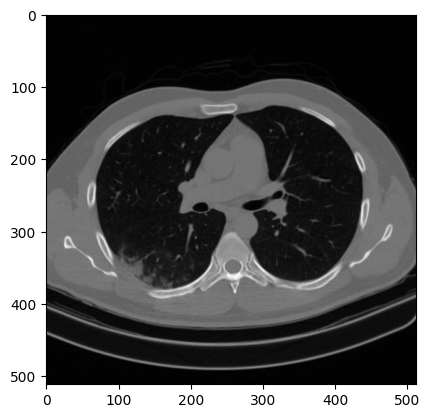

In [ ]:
img = cv2.imread('/content/drive/MyDrive/mini_project_6sem/dataset/covid/P040_105.png')
plt.imshow(img)
print(img.shape)

(512, 512, 3)


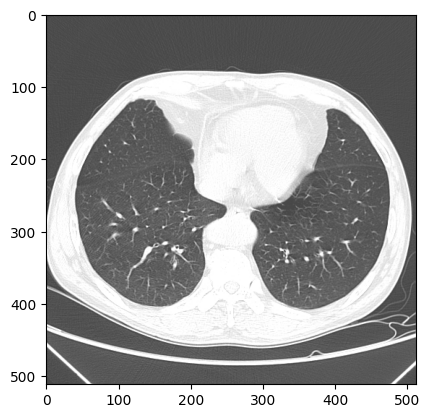

In [ ]:
img = cv2.imread('/content/drive/MyDrive/mini_project_6sem/dataset/normal/55dd (27).jpg')
plt.imshow(img)
print(img.shape)

In [ ]:
def make_dataset(source_folder,destination_folder):
  image_files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
  i=0
  for image_file in image_files:
    try:
        i=i+1
        shutil.copy(os.path.join(source_folder, image_file), os.path.join(destination_folder, image_file))
        print(f"Copied {image_file} successfully!")
    except Exception as e:
        print(f"Error copying {image_file}: {str(e)}")
    if i==1000:
      break


In [ ]:
#make_dataset("/content/drive/MyDrive/mini_project_6sem/curated_data/curated_data/3CAP","/content/drive/MyDrive/mini_project_6sem/dataset/pneumonia")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#crate the image generator to (resize, normalize, filter and augmantation) images
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      validation_split=0.3,
      fill_mode='nearest')


# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/mini_project_6sem/dataset',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=64,
        subset='training',
        shuffle = True,
        # Since we use categorical_crossentropy loss, 
        class_mode='categorical')

# Flow validation images in batches of 64 using validation_datagen generator
validation_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/mini_project_6sem/dataset', # This is the source directory for validation images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=64,
        subset='validation',
        shuffle = True,
        # Since we use categorical_crossentropy loss, 
        class_mode='categorical')

Found 4200 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


In [ ]:
categories = train_generator.class_indices

In [ ]:
categories

{'covid': 0, 'normal': 1, 'pneumonia': 2}

In [ ]:
# Get a batch of images and labels
x_batch, y_batch = next(train_generator)

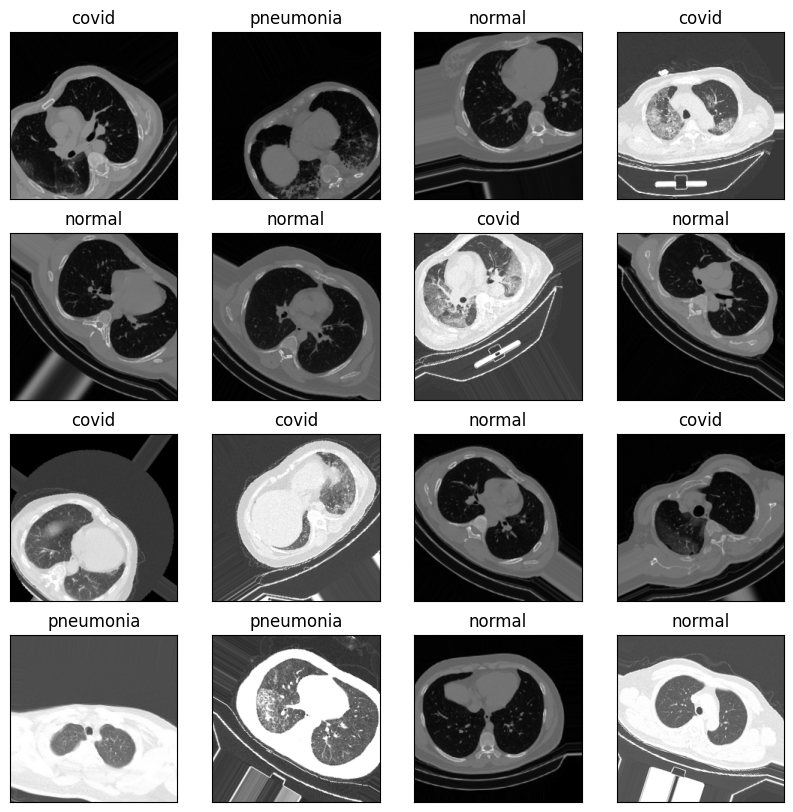

In [ ]:
# Plot the images and categories
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(x_batch[i])
    # Get the category
    category = list(train_generator.class_indices.keys())[list(y_batch[i]).index(1)]
    # Set the title to the category
    ax.set_title(category)
    # Remove the axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
from keras.layers import Reshape
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Activation,BatchNormalization,Dropout,Flatten
import tensorflow as tf
import keras
from keras.applications import ResNet152V2
from keras.layers import Conv2D, TimeDistributed,Lambda, MaxPooling2D,AveragePooling2D, GRU,Bidirectional

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 29.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=574b02f5c97f08ab3bce7f914f86c571ceb9389629aa8590bea761f2ef7a7a46
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# This script needs these libraries to be installed: 
#   tensorflow, numpy

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

import random
import numpy as np
import tensorflow as tf


# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="chel bhai start ho ja",

    # track hyperparameters and run metadata with wandb.config
    config={
        "dropout": random.uniform(0.01, 0.80),
        "loss": "categorical_crossentropy",
        "epoch": 8,
    }
)

# [optional] use wandb.config as your config
config = wandb.config

wandb: Currently logged in as: miniproject678sem (name-nhi-socha). Use `wandb login --relogin` to force relogin


In [ ]:
def createvgg19model():
  # Load pre-trained VGG16 model
  vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  # Freeze the layers in the pre-trained model
  for layer in vgg19.layers:
    layer.trainable = True
  model = Sequential()
  model.add(vgg19)
  #cnn architecture 
  model.add(Reshape((7,7,512),input_shape=(-1,7,7,512)))
  model.add(Conv2D(128, (5, 5),padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(128, (5, 5),padding='same'))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((3,3),(3,3)))
  model.add(Dropout(config.dropout))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dropout(config.dropout))
  model.add(Dense(3,activation='softmax'))
  return model

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 reshape (Reshape)           (None, 7, 7, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 128)         1638528   
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         409728    
                                                                 
 activation_1 (Activation)   (None, 7, 7, 128)         0         
                                                         

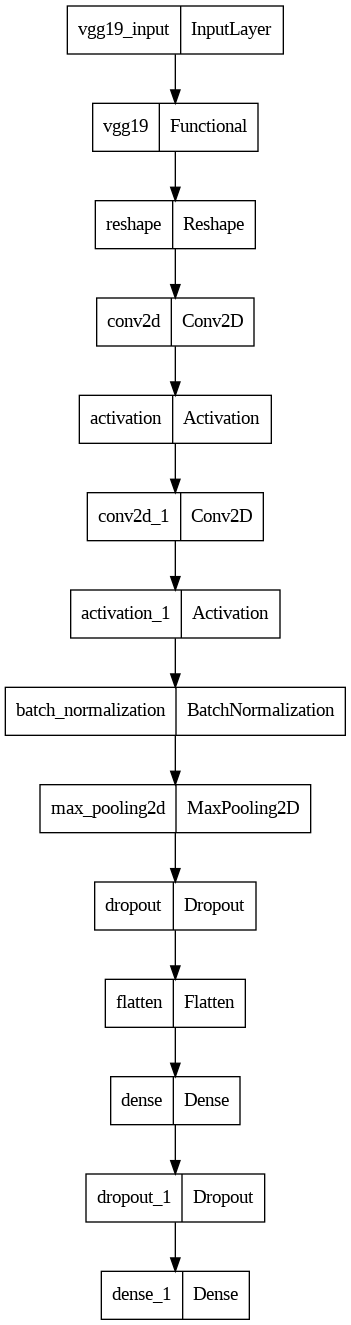

In [ ]:
model = createvgg19model()
model.summary()
keras.utils.plot_model(model, "vgg19_cnn.png")

In [ ]:
# compile the model
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate = 0.000009, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              loss=config.loss,
              metrics= [tf.keras.metrics.Accuracy(name='accuracy'),
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')]
              )

In [ ]:
# WandbMetricsLogger will log train and validation metrics to wandb
# WandbModelCheckpoint will upload model checkpoints to wandb
history = model.fit(train_generator,
                    epochs=config.epoch,
                    validation_data=validation_generator,
                    callbacks=[
                      WandbMetricsLogger(log_freq=5),
                      WandbModelCheckpoint("models")
                    ])

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Epoch 1/8


In [ ]:
#creating resnet152+bidirectional GRU
def creategrumodel():
   top_model = Sequential()
   top_model.add(ResNet152V2(include_top=False,weights="imagenet",input_shape=(224,224,3)))
   top_model.add(Reshape((7,7,2048), input_shape=(-1,7,7,2048)))
   top_model.add(TimeDistributed(Flatten()))
   top_model.add(Bidirectional(GRU(256, return_sequences=False)) )  
   top_model.add(config.dropout)
   top_model.add(Dense(3, activation='softmax'))
   return top_model


In [ ]:
model2 = creategrumodel()

model2.summary()
#plot the model as a graph
keras.utils.plot_model(model2, "resnet_152_bigru.png")